# Google drive mount & Importing libraries

In [187]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터 불러오기 및 전처리

In [189]:
# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/gradProject_studies/cocktail_data.csv')

In [190]:
# 사용하지 않을 column 삭제
data = data.drop(columns=['맛','레시피*', '키워드', '설명*', '신맛내는거'], axis=1)

# NaN값 포함된 data 삭제
data = data.dropna()

# 인덱스 재설정
data = data.reset_index(drop=True)

In [191]:
# 당도 값을 공백 제외한 값으로 수정
for i in range(len(data['당도*'])):
  data['당도*'][i] = data['당도*'][i].replace(" " , "")

<ipython-input-191-debedf1616cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['당도*'][i] = data['당도*'][i].replace(" " , "")


In [192]:
# 당도 수치화하여 수정
data['당도*'].replace('쓴맛', 1, inplace=True)
data['당도*'].replace('중간쓴맛', 2, inplace=True)
data['당도*'].replace('중간맛', 3, inplace=True)
data['당도*'].replace('중간단맛', 4, inplace=True)
data['당도*'].replace('단맛', 5, inplace=True)

In [193]:
# 색상 rgb값 column 생성
data['red'] = ""
data['green'] = ""
data['blue'] = ""

for i in range(len(data)):
  data['red'][i] = int('0x' + data['색상*'][i][1:3], 16)
  data['green'][i] = int('0x' + data['색상*'][i][3:5], 16)
  data['blue'][i] = int('0x' + data['색상*'][i][5:], 16)

<ipython-input-193-777ab554a379>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['red'][i] = int('0x' + data['색상*'][i][1:3], 16)
<ipython-input-193-777ab554a379>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['green'][i] = int('0x' + data['색상*'][i][3:5], 16)
<ipython-input-193-777ab554a379>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['blue'][i] = int('0x' + data['색상*'][i][5:], 16)


In [194]:
# 베이스 원-핫 인코딩 처리하여 column 추가
import numpy as np 

base_dummies = pd.get_dummies(data['베이스*'])
data = pd.concat([data, base_dummies], axis=1)
data_이름 = data['이름*']
data = data.drop(['색상*', '베이스*','이름*'], axis=1)

data

,당도*,도수*,red,green,blue,beer,brandy,gin,liqueur,non-alcoholic,rum,tequila,vodka,whisky,wine&champagne
0,1,37.0,195,156,61,0,0,1,0,0,0,0,0,0,0
1,3,30.0,178,177,195,0,0,1,0,0,0,0,0,0,0
2,3,33.0,70,114,74,0,0,1,0,0,0,0,0,0,0
3,1,32.0,191,173,157,0,0,1,0,0,0,0,0,0,0
4,1,28.0,189,187,199,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,3,7.9,131,126,0,1,0,0,0,0,0,0,0,0,0
795,3,7.9,47,32,30,1,0,0,0,0,0,0,0,0,0
796,1,36.0,144,103,70,1,0,0,0,0,0,0,0,0,0
797,5,8.1,172,116,0,1,0,0,0,0,0,0,0,0,0


# 군집화 테스트

In [195]:
# K-means clustering 사용할 것
from sklearn.cluster import KMeans

In [196]:
# 실루엣 계수 시각화 함수. 파이썬 머신러닝 완벽가이드 교재 코드 참고

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [197]:
# 클러스터링 시각화 함수. 파이썬 머신러닝 완벽가이드 교재 코드 참고

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*', 'P', 'D', 'H', '.', '<', '>', '1', '2', '3', '4', '8']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

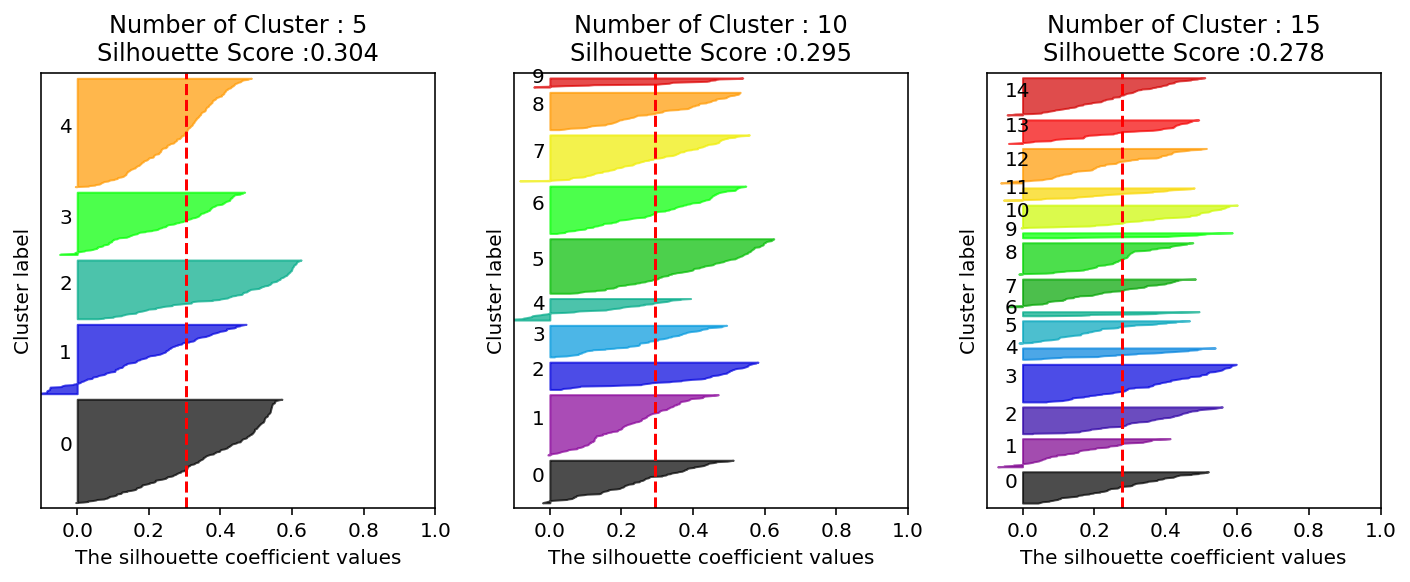

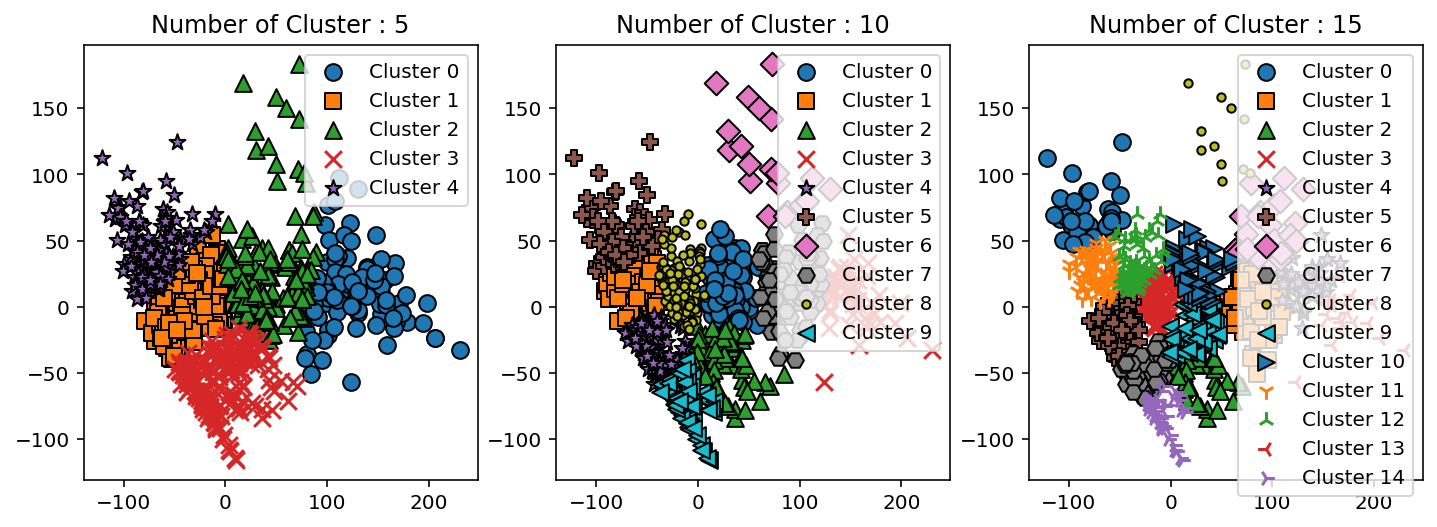

In [198]:
# 군집 개수에 따른 시각화 결과 확인
visualize_silhouette([5,10,15],data)
visualize_kmeans_plot_multi([5,10,15],data)

# 사용자 입력: 맛, 도수 & 사용자 입력을 Input data로 추가

In [199]:
# 맛: 쓴맛, 중간쓴맛, 중간맛, 중간단맛, 단맛
print("맛을 입력해주세요.")
taste = input()
print("입력한 맛: " + taste)

if(taste == "쓴맛"):
  taste_data = 1

if(taste == "중간쓴맛"):
  taste_data = 2

if(taste == "중간맛"):
  taste_data = 3
 
if(taste == "중간단맛"):
  taste_data = 4

if(taste == "단맛"):
  taste_data = 5
  
print(taste_data)

맛을 입력해주세요.
쓴맛
입력한 맛: 쓴맛
1


In [200]:
# 도수: 상,중,하
print("도수를 입력해주세요.")
alcohol_level = input()
print("도수: " + alcohol_level)

if(alcohol_level == "상"):
  level_data = 35

if(alcohol_level == "중"):
  level_data = 25
 
if(alcohol_level == "하"):
  level_data = 15

print(level_data)

도수를 입력해주세요.
중
도수: 중
25


In [201]:
# 기존 칵테일 데이터에 사용자 데이터 추가
new_data = {
    '당도*':[taste_data], 
    '도수*':[level_data], 
    'red':[0], 
    'green':[0], 
    'blue':[0], 
    'beer':[0], 
    'brandy':[0], 
    'gin':[0], 
    'liqueur':[0], 
    'non-alcoholic':[0], 
    'rum':[0], 
    'tequila':[0], 
    'vodka':[0], 
    'whisky':[0], 
    'wine&champagne':[0]
}
new_df = pd.DataFrame(new_data)
 
data = pd.concat([data,new_df])

# 군집화 실행하여 같은 군집 내의 data 확인

In [202]:
# 군집화 실행
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10).fit(data)

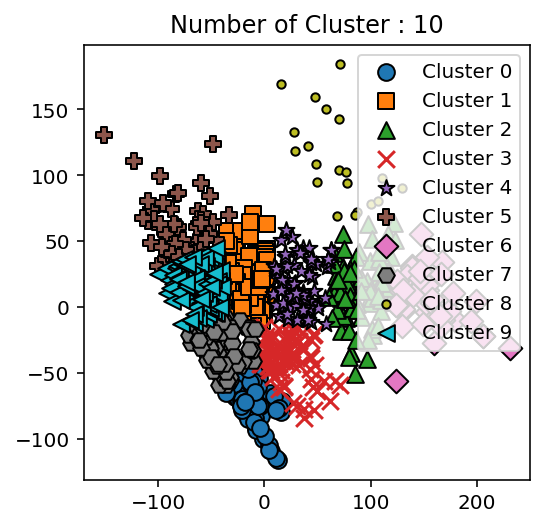

In [203]:
# 군집 모양 확인

from sklearn import preprocessing
from sklearn.decomposition import PCA

fig, axs = plt.subplots(figsize=(4, 4), nrows=1, ncols=1)
    
# 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data)
dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
 
# KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
clusterer = KMeans(n_clusters = 10, max_iter=500, random_state=0)
cluster_labels = clusterer.fit_predict(pca_transformed)
dataframe['cluster']=cluster_labels
        
unique_labels = np.unique(clusterer.labels_)
markers=['o', 's', '^', 'x', '*', 'P', 'D', 'H', '.', '<', '>', '1', '2', '3', '4', '8']
       
# 클러스터링 결과값 별로 scatter plot 으로 시각화
for label in unique_labels:
    label_df = dataframe[dataframe['cluster']==label]
    if label == -1:
        cluster_legend = 'Noise'
    else :
        cluster_legend = 'Cluster '+str(label)           
    axs.scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                edgecolor='k', marker=markers[label], label=cluster_legend)

axs.set_title('Number of Cluster : '+ str(10))    
axs.legend(loc='upper right')
  
plt.show()

In [204]:
# 이름과 군집인덱스를 column으로 가지는 cluster_map 데이터프레임 생성
cluster_map = pd.DataFrame()
cluster_map['data_index'] = data_이름
cluster_map.loc[cluster_map.shape[0]] = ['user data']
cluster_map['cluster'] = km.labels_

# 사용자 군집 내의 데이터 확인
for i in range(0,10):
  if ( len(cluster_map)-1 in cluster_map[cluster_map.cluster == i].index) == True:
    print("사용자 군집:", i)
    user_group = i

print(cluster_map[cluster_map.cluster == user_group])
index_list = list(cluster_map[cluster_map.cluster == user_group].index)

사용자 군집: 5


,data_index,cluster
2,푸른 산호초,5
9,어라운드 더 월드,5
24,카루소,5
28,그린 드래건,5
64,세븐스 헤븐 No 1,5
82,바텐더,5
83,퍼펙트 마티니,5
88,파리지앵,5
121,메리 위도,5
165,케이프 코더,5


# 사용자 입력: 재료

In [205]:
# 재료 물어보기
print("재료를 입력해주세요.")
recipe = input()
print("입력한 재료: " + recipe)

재료를 입력해주세요.
민트
입력한 재료: 민트


# 레시피 데이터 불러오기 & 군집 데이터와 합치기

In [207]:
# 칵테일 데이터에서 레시피를 리스트 형태로 불러오기
recipe_data = pd.read_csv('/content/drive/MyDrive/gradProject_studies/cocktail_data.csv', low_memory=False, index_col=0)
recipe_data = recipe_data.drop(columns=['맛','당도*', '도수*', '색상*', '베이스*', '키워드', '설명*', '신맛내는거'], axis=1)
recipe_list = list(recipe_data['레시피*'])

In [208]:
# 사용자 군집 내 데이터의 레시피 리스트 생성
final_recipe = [];

for i in range(len(index_list)):
      final_recipe.append(recipe_list[index_list[i]])
      
print(final_recipe)

['드라이 진, 페퍼민트 그린', '드라이 진, 그린 페퍼민트, 파인애플 주스', '드라이 진, 듀보네, 크림 드 만다린', '드라이 진, 라임 주소', '드라이 진, 벚꽃 리큐르(루메즈 샐러드)', '드라이 진, 드라이 베르무트, 페르노, 페퍼민트 화이트', '드라이 진, 체리, 드라이 베르무트, 듀보네, 그랑 마니에', '드라이 진, 아프리콧 브랜디, 오렌지 주스', '드라이 진, 아프리콧 브랜디, 코인트로, 갈리아노, 레몬 주스', '보드카, 카카오 리큐르, 레몬 주스, 그레나덴 시럽', '보드카, 알리제 패션 리큐르, 그레이프 프루트 주스, 그레나덴 시럽', '보드카, 칼루아', '화이트 럼, 다크 럼, 설탕, 미네랄 워터, 민트 잎', '골드 럼, 코안트로, 크림 드 카카오, 아이스 커피, 코코넛 밀크', '브랜디, 스위트 베르무트, 앙고스트라 비터, 페르노', '브랜디, 화이트 럼, 코안트로, 레몬 주스', '브랜디, 드라이 베르무트, 마라스키노, 크림 드 민트 화이트', '브랜디, 파인애플 주스, 샴페인', '브랜디, 스위트 베르무트, 설탕, 앙고스트라 비터', '브랜디, 포트와인, 드라이 베르무트', '브랜디, 릴레 브랑, 레몬 주스, 화이트 큐라소', '버번 위스키, 엑스트라 드라이 베르무트, 레몬 주스', '스카치 위스키, 드라이 베르무트, 레몬 주스, 오렌지 비터', '위스키, 드라이 베르무트, 그레이프 프루트 주스', '버번 위스키, 페르노, 아니세트, 앙고스트라 비터', '스카치 위스키, 설탕 시럽, 앙고스트라 비터', '테킬라, 티아 마리아, 코안트로', '테킬라, 칼루아', '테킬라, 파인애플 주스, 플레시 라임 주스', '샤르도네, 시트론 제니버, 워터멜론, 마라스키노', '오렌지 주스, 레몬 주스, 설탕 가루, 브루고뉴 와인', '샴페인, 블랙 삼브카', '갈리아노, 크림 드 카카오 화이트, 생크림', '크림 드 노와요, 크림 드 카카오 화이트, 생크림', '커피 리큐르, 갈리아노, 생크림', '그레나덴, 오렌지 주스, 계란 노른

In [209]:
# 이름, 군집, 레시피를 담은 user_cluster 데이터프레임 생성
# cluster_map과 final_recipe를 합친다.
user_cluster = cluster_map[cluster_map.cluster == user_group]
user_cluster.drop(user_cluster.tail(1).index,inplace=True) # drop last n rows
user_cluster['레시피*'] = final_recipe
user_cluster

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-209-ebaf8d47537b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_cluster['레시피*'] = final_recipe


,data_index,cluster,레시피*
2,푸른 산호초,5,"드라이 진, 페퍼민트 그린"
9,어라운드 더 월드,5,"드라이 진, 그린 페퍼민트, 파인애플 주스"
24,카루소,5,"드라이 진, 듀보네, 크림 드 만다린"
28,그린 드래건,5,"드라이 진, 라임 주소"
64,세븐스 헤븐 No 1,5,"드라이 진, 벚꽃 리큐르(루메즈 샐러드)"
82,바텐더,5,"드라이 진, 드라이 베르무트, 페르노, 페퍼민트 화이트"
83,퍼펙트 마티니,5,"드라이 진, 체리, 드라이 베르무트, 듀보네, 그랑 마니에"
88,파리지앵,5,"드라이 진, 아프리콧 브랜디, 오렌지 주스"
121,메리 위도,5,"드라이 진, 아프리콧 브랜디, 코인트로, 갈리아노, 레몬 주스"
165,케이프 코더,5,"보드카, 카카오 리큐르, 레몬 주스, 그레나덴 시럽"


# 레시피에 대해 TF-IDF 기반 코사인 유사도 구하기

In [210]:
# 각 데이터간의 cosine similarity를 도출하는 함수
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [211]:
# 레시피에 대해서 TF-IDF 행렬을 구한 후 행렬의 크기를 출력
from sklearn.feature_extraction.text import TfidfVectorizer

final_recipe.append(recipe)
# print(final_recipe)

doc_list = final_recipe

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)

print(feature_vect_simple.shape)
print(type(feature_vect_simple))

(43, 83)
<class 'scipy.sparse.csr.csr_matrix'>


In [213]:
# 사용자 재료 입력에 대한 cosime simularity 확인

sim_list = []

# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

for i in range(len(feature_vect_dense)):
  #첫번째 문장과 두번째 문장의 feature vector  추출
  vect1 = np.array(feature_vect_dense[len(feature_vect_dense)-1]).reshape(-1,)
  vect2 = np.array(feature_vect_dense[i]).reshape(-1,)

  #첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
  similarity_simple = cos_similarity(vect1, vect2)
  # print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))
  sim_list.append(similarity_simple)

sim_list.pop()
sim_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3628365069674972,
 0.0,
 0.0,
 0.0,
 0.4238810762527307,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4615361486702287,
 0.0]

# 코사인 유사도 column 추가

In [215]:
# user_cluster에 유사도 column 추가
user_cluster['유사도'] = sim_list

<ipython-input-215-57f23d1883ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_cluster['유사도'] = sim_list


In [216]:
# user_cluster 확인
user_cluster

,data_index,cluster,레시피*,유사도
2,푸른 산호초,5,"드라이 진, 페퍼민트 그린",0.000000
9,어라운드 더 월드,5,"드라이 진, 그린 페퍼민트, 파인애플 주스",0.000000
24,카루소,5,"드라이 진, 듀보네, 크림 드 만다린",0.000000
28,그린 드래건,5,"드라이 진, 라임 주소",0.000000
64,세븐스 헤븐 No 1,5,"드라이 진, 벚꽃 리큐르(루메즈 샐러드)",0.000000
82,바텐더,5,"드라이 진, 드라이 베르무트, 페르노, 페퍼민트 화이트",0.000000
83,퍼펙트 마티니,5,"드라이 진, 체리, 드라이 베르무트, 듀보네, 그랑 마니에",0.000000
88,파리지앵,5,"드라이 진, 아프리콧 브랜디, 오렌지 주스",0.000000
121,메리 위도,5,"드라이 진, 아프리콧 브랜디, 코인트로, 갈리아노, 레몬 주스",0.000000
165,케이프 코더,5,"보드카, 카카오 리큐르, 레몬 주스, 그레나덴 시럽",0.000000


# 군집 내 최대 유사도를 지니는 데이터 출력

In [217]:
# 군집 내 사용자 입력과 최대 유사도를 지니는 데이터의 유사도, 인덱스 확인

max = 0;

# print(len(list(user_cluster['유사도'])))
for i in range(len(list(user_cluster['유사도']))):
  if list(user_cluster['유사도'])[i] > max:
    max = list(user_cluster['유사도'])[i]

print(max)

for j in range(len(list(user_cluster['유사도']))):
  if (list(user_cluster['유사도'])[j] == max):
    max_cos = j
    print(j)

0.4615361486702287
40


In [218]:
# 최종 추천할 데이터의 이름 출력
final_result = list(user_cluster['data_index'])
final_result[max_cos]

'모카 쿠로나마'